# Cleaning inputs for WCM

In [2]:
# Base
import os
import re
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt

# Analysis
import pyswarms as ps
from scipy import special as sp
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.signal import savgol_filter as sfilter

# # Geospatial
# import fiona
# import xarray as xr
# import hydroeval as he
# # import geopandas as gpd
# # from maps_original import *

# Graphics
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# LAI

In [172]:
df_lai = pd.read_csv(f'LAI_Budrio.csv', delimiter = ",", header=None)
df_lai['Date'] = pd.date_range(start="2017-1-10",end="2017-12-31")

<AxesSubplot:>

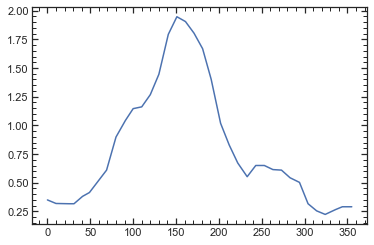

In [173]:
df_lai[1].plot()

In [174]:
df_lai = df_lai.drop(0, axis=1).rename(columns={1:'LAI[m2/m2]'})
df_lai

,LAI[m2/m2],Date
0,0.35038,2017-01-10
1,0.34728,2017-01-11
2,0.34418,2017-01-12
3,0.34108,2017-01-13
4,0.33797,2017-01-14
...,...,...
351,0.29069,2017-12-27
352,0.29069,2017-12-28
353,0.29069,2017-12-29
354,0.29069,2017-12-30


# Satellite and in-situ data: $\sigma^0$, angle, SM

In [175]:
df_sat = pd.read_csv(f'Golden_GEE.csv', delimiter = "\t", index_col=0).rename(columns={'Date':'DateTime_sat'})
df_sat['Date'] = pd.to_datetime(pd.to_datetime(df_sat['DateTime_sat'].astype('str')).apply(lambda x: x.date()))
df_sat

,Angle[°],DateTime_sat,Geometry,Orb,Pass,VH[dB],VH_dev[dB],VV[dB],VV_dev[dB],SWC[m3/m3],Pioggia[mm],Irrigazione[mm],Temperatura[°C],Date
0,31.383728,2017-04-04 07:00:00,Budrio_half-right,168,DESCENDING,-20.830018,1.904476,-11.914824,1.816203,0.170173,0.0,0.0,8.7339,2017-04-04
1,41.390998,2017-04-05 07:00:00,Budrio_half-right,95,DESCENDING,-22.619971,2.632017,-10.937961,2.027644,0.147105,0.0,0.0,11.8548,2017-04-05
2,37.171040,2017-04-06 19:00:00,Budrio_half-right,117,ASCENDING,-22.724337,2.135879,-12.247353,1.337440,0.150527,0.0,0.0,15.6591,2017-04-06
3,31.418842,2017-04-10 07:00:00,Budrio_half-right,168,DESCENDING,-22.204781,2.111794,-12.161258,1.736876,0.159550,0.0,0.0,8.5507,2017-04-10
4,41.407985,2017-04-11 07:00:00,Budrio_half-right,95,DESCENDING,-23.842131,2.747528,-12.833449,1.617987,0.160673,0.0,0.0,10.5575,2017-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,41.380256,2017-10-26 07:00:00,Budrio_half-right,95,DESCENDING,-19.882918,1.802317,-10.557746,1.581814,0.155637,0.0,0.0,5.1388,2017-10-26
103,37.172670,2017-10-27 19:00:00,Budrio_half-right,117,ASCENDING,-19.356794,1.974589,-11.910805,1.812534,0.155525,0.0,0.0,14.4822,2017-10-27
104,31.274119,2017-10-31 06:00:00,Budrio_half-right,168,DESCENDING,-20.319962,2.037577,-8.338587,1.739120,0.167105,0.0,0.0,4.9978,2017-10-31
105,41.391327,2017-11-01 06:00:00,Budrio_half-right,95,DESCENDING,-19.798864,2.154767,-10.685643,1.487615,0.124052,NaN,0.0,NaN,2017-11-01


# Merge inputs on dates

In [176]:
df_tot = pd.merge(left=df_lai, right=df_sat, how='right', on='Date'); df_tot

,LAI[m2/m2],Date,Angle[°],DateTime_sat,Geometry,Orb,Pass,VH[dB],VH_dev[dB],VV[dB],VV_dev[dB],SWC[m3/m3],Pioggia[mm],Irrigazione[mm],Temperatura[°C]
0,0.95176,2017-04-04,31.383728,2017-04-04 07:00:00,Budrio_half-right,168,DESCENDING,-20.830018,1.904476,-11.914824,1.816203,0.170173,0.0,0.0,8.7339
1,0.96509,2017-04-05,41.390998,2017-04-05 07:00:00,Budrio_half-right,95,DESCENDING,-22.619971,2.632017,-10.937961,2.027644,0.147105,0.0,0.0,11.8548
2,0.97843,2017-04-06,37.171040,2017-04-06 19:00:00,Budrio_half-right,117,ASCENDING,-22.724337,2.135879,-12.247353,1.337440,0.150527,0.0,0.0,15.6591
3,1.03180,2017-04-10,31.418842,2017-04-10 07:00:00,Budrio_half-right,168,DESCENDING,-22.204781,2.111794,-12.161258,1.736876,0.159550,0.0,0.0,8.5507
4,1.04320,2017-04-11,41.407985,2017-04-11 07:00:00,Budrio_half-right,95,DESCENDING,-23.842131,2.747528,-12.833449,1.617987,0.160673,0.0,0.0,10.5575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.52141,2017-10-26,41.380256,2017-10-26 07:00:00,Budrio_half-right,95,DESCENDING,-19.882918,1.802317,-10.557746,1.581814,0.155637,0.0,0.0,5.1388
103,0.51774,2017-10-27,37.172670,2017-10-27 19:00:00,Budrio_half-right,117,ASCENDING,-19.356794,1.974589,-11.910805,1.812534,0.155525,0.0,0.0,14.4822
104,0.50308,2017-10-31,31.274119,2017-10-31 06:00:00,Budrio_half-right,168,DESCENDING,-20.319962,2.037577,-8.338587,1.739120,0.167105,0.0,0.0,4.9978
105,0.48448,2017-11-01,41.391327,2017-11-01 06:00:00,Budrio_half-right,95,DESCENDING,-19.798864,2.154767,-10.685643,1.487615,0.124052,NaN,0.0,NaN


In [177]:
save = input("Wanna save in root directory? [y/n] ")
if save=='y': df_tot.to_csv(f'data_in.csv', sep = '\t')

Wanna save in root directory? [y/n]  y


# Data quality check

## Observed satellite data

### VV from GEE is consistent with VV from SNAP processing

In [178]:
database = pd.ExcelFile('Gold_Sentinel_PGRS.xlsx', engine='openpyxl')
sp17 = database.parse('SP17 Half+Right')['<σ0> (VV) (campo "safe_half+right") [dB]'].values
au17 = database.parse('AU17 Half+Right')['<σ0> (VV) (campo "safe_half+right") [dB]'].values

In [183]:
tot17 = np.append(sp17,au17)

In [184]:
tot17

array([-11.980069, -11.049848, -12.432093, -12.109891, -12.953127,
       -13.067851, -11.798966,  -7.978895,  -7.879071,  -9.320411,
       -11.481519, -13.158021,  -5.8796  , -10.304084, -11.862358,
        -6.014759,  -6.773028,  -5.850546,  -6.194148,  -8.097759,
        -6.969378,  -7.072515, -11.996259, -13.345336, -10.350719,
       -10.331701,  -5.894563,  -9.256175, -10.988318,  -3.979582,
        -7.948883, -10.440001, -10.252225, -10.649015, -11.353739,
        -2.947058,  -6.638514,  -9.939132,  -7.418857, -10.101637,
       -12.261216,  -8.605926, -10.342169, -11.907838,  -8.741254,
       -10.76816 , -11.978297,  -8.51399 , -10.799419, -12.331056])

In [185]:
sp17_gee = df_tot['VV[dB]'].values[0:25]
au17_gee = df_tot['VV[dB]'].values[-25:]
tot17_gee = np.append(sp17_gee,au17_gee)

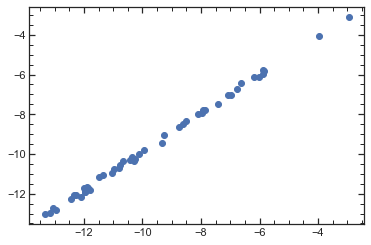

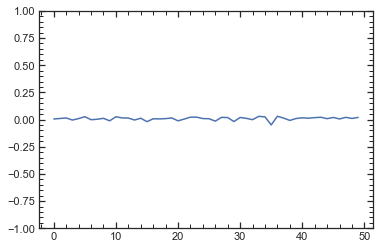

R = 0.9992330775544246
Are data consistent? (R>0.99) yes


In [186]:
plt.scatter(tot17, tot17_gee)
plt.show()
plt.plot((tot17-tot17_gee)/tot17)
plt.ylim(-1,1)
plt.show()

R=np.corrcoef(tot17,tot17_gee,rowvar=False)[0][1]; print('R =', R)
print('Are data consistent? (R>0.99)', 'yes' if R>0.99 else 'no')

### Cosine normalization